# Задание

1. Загрузите набор данных lenta-ru-news с помощью библиотеки Corus для задачи классификации текстов по топикам (пригодятся атрибуты title, text, topic)- **1 балл**
2. Подготовьте данные к обучению: - **3 балла**
    - Предобработайте данные: реализуйте оптимальную, на ваш взгляд, предобработку текстов (нормализация, очистка, стемминг/лемматизация и т.п.) и таргета.
    - **hint**: для ускорения обработки  и обучения можно ограничиться не всем датасетом, а его репрезентативной частью, например, размера 100_000.
    - Кратко опишите пайплайн, на котором остановились, и почему.
    - Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20. В качестве целевой переменной используйте атрибут `topic`
3. Замерьте базовое качество с любым dummy-бейзлайном - **0.5 балла**
4. Обучите модель `sklearn.linear_model.LogisticRegression` с двумя вариантами векторизации: **2 балла**
  - `sklearn.feature_extraction.text.CountVectorizer`
  - `sklearn.feature_extraction.text.TfidfVectorizer`
5. Попробуйте улучшить качество, подобрав оптимальные гиперпараметры трансформаций и модели на кросс-валидации **1 балл**
6. Оцените качество лучшего пайплайна на отложенной выборке - **0.5 балла**

**Общее**

- Принимаемые решения обоснованы (почему выбрана определенная архитектура/гиперпараметр/оптимизатор/преобразование и т.п.) - **1 балл**
- Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - **1 балл**

## Этап 0 - Подготовка

### Импортируем необходимые библиотеки и компоненты

In [1]:
import re
import string
import random
import warnings

import polars as pl
import numpy as np
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
from corus import load_lenta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

### Фиксируем seed'ы

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Этап 1 - Загрузка данных

### Загрузим сырые данные

In [3]:
data = load_lenta("../data/raw/lenta-ru-news.csv.gz")

In [4]:
type(data)

generator

In [5]:
target_columns = ["title", "topic", "text"]
data_dict = {c: [] for c in target_columns}

for item in data:
    for column in target_columns:
        data_dict[column].append(eval(f"item.{column}"))

### Преобразуем к формату polars

In [6]:
df = pl.DataFrame(data_dict)

In [7]:
print(df.shape)
display(df.sample(3))

(739351, 3)


title,topic,text
str,str,str
"""Apple стала крупнейшим произво…","""Экономика""","""Корпорация Apple обошла Motoro…"
"""Один из основателей Mail.Ru пр…","""Экономика""","""Один из основателей Mail.Ru Ми…"
"""Международный союз биатлонисто…","""Спорт""","""Исполком Международного союза …"


### Минимально обработаем данные

In [8]:
df = df.select(["title", "text", "topic"])
df = df.with_columns((pl.col("title") + "\n" + pl.col("text")).alias("content"))

In [9]:
df = df.drop("title", "text")

In [10]:
df.write_parquet("../data/raw/hw_1.parquet")

## Этап 2 - EDA

In [ ]:
df = pl.read_parquet("../data/raw/hw_1.parquet")

### Рассмотрим target

In [11]:
topic_counts = df.group_by("topic").agg(pl.count("topic").alias("count")).sort("count", descending=True)
topic_counts_pd = topic_counts.to_dict(as_series=False)

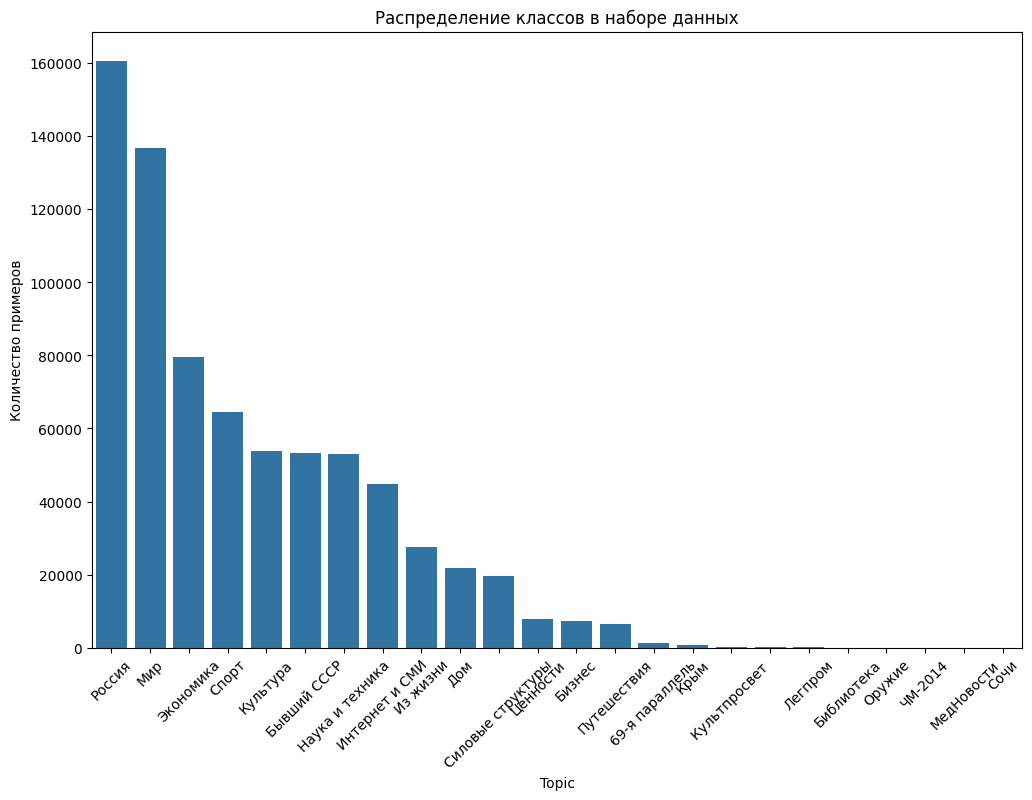

In [12]:
plt.figure(figsize=(12, 8))
sns.barplot(x=topic_counts_pd["topic"], y=topic_counts_pd["count"])
plt.xticks(rotation=45)
plt.title("Распределение классов в наборе данных")
plt.xlabel("Topic")
plt.ylabel("Количество примеров")
plt.show()

### Отсчём небольшие классы

Модель не сможет уловить зависимости, на этих классах качество будет низким.

Поставим умозрительный порог в 1000 сэмплов.

In [13]:
valid_topics = topic_counts.filter(pl.col("count") >= 1000)["topic"].to_list()
df = df.filter(pl.col("topic").is_in(valid_topics))

In [14]:
df.shape

(737956, 2)

### Посмотрим на распределение длин

In [16]:
df_char_len = df.with_columns(pl.col("content").str.len_chars().alias("char_len"))

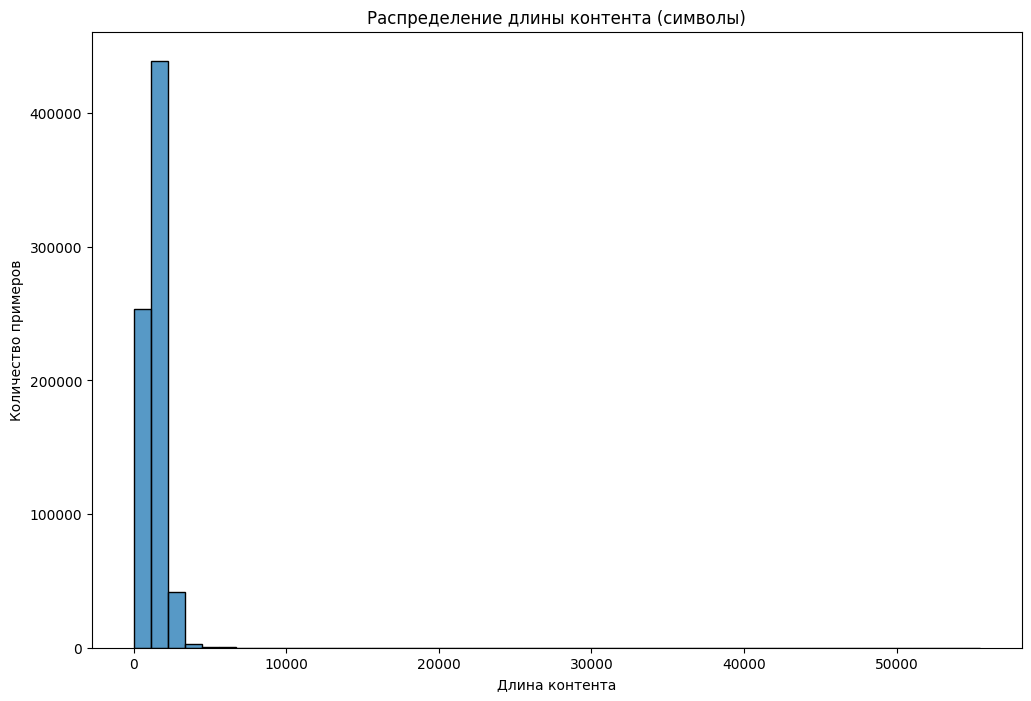

In [18]:
plt.figure(figsize=(12, 8))
sns.histplot(df_char_len["char_len"].to_list(), bins=50)
plt.title("Распределение длины контента (символы)")
plt.xlabel("Длина контента")
plt.ylabel("Количество примеров")
plt.show()

In [20]:
df_word_count = df.with_columns(pl.col("content").str.split(" ").list.len().alias("word_count"))

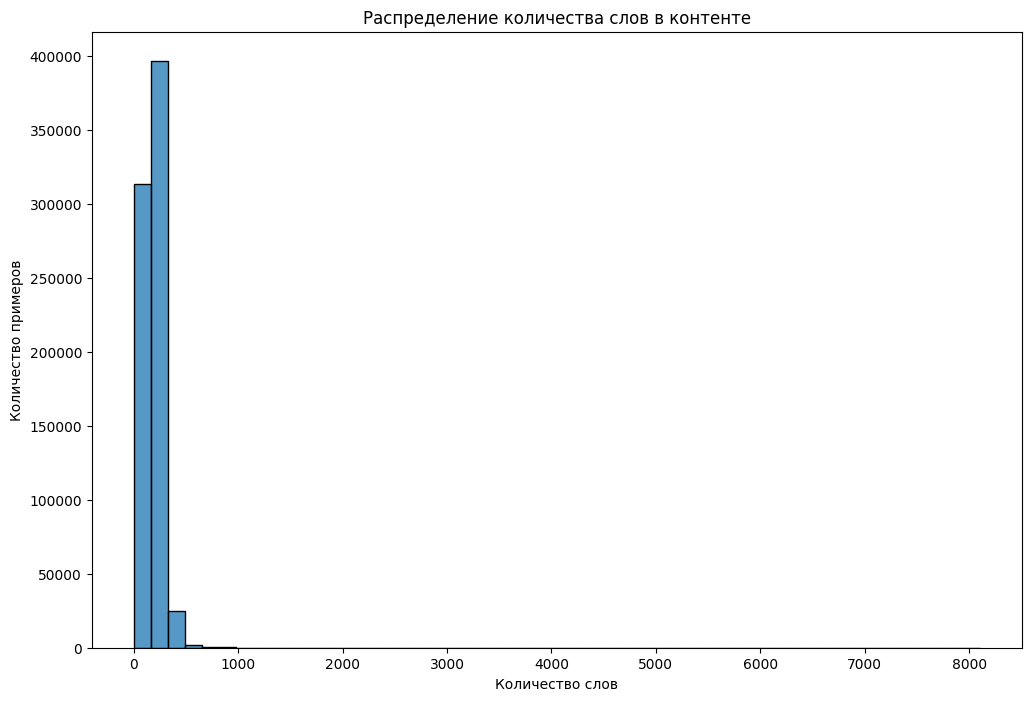

In [22]:
plt.figure(figsize=(12, 8))
sns.histplot(df_word_count["word_count"].to_list(), bins=50)
plt.title("Распределение количества слов в контенте")
plt.xlabel("Количество слов")
plt.ylabel("Количество примеров")
plt.show()

### Замечены выбросы

Удалим их с помощью IQR

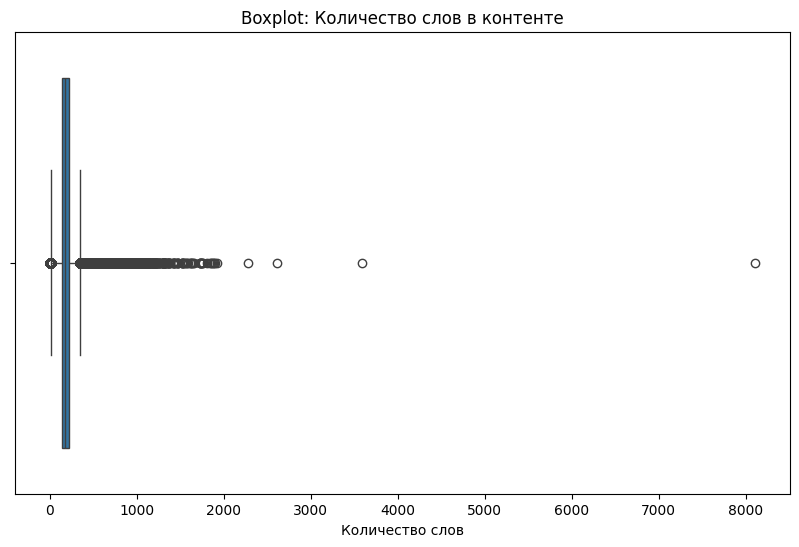

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_word_count["word_count"].to_list())
plt.title("Boxplot: Количество слов в контенте")
plt.xlabel("Количество слов")
plt.show()

In [25]:
q1 = df_word_count.select(pl.col("word_count").quantile(0.25)).item()
q3 = df_word_count.select(pl.col("word_count").quantile(0.75)).item()
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}")
print(f"Границы выбросов: [{lower_bound}, {upper_bound}]")

Q1: 138.0, Q3: 222.0, IQR: 84.0
Границы выбросов: [12.0, 348.0]


In [26]:
df_filtered = df_word_count.filter((pl.col("word_count") >= lower_bound) & (pl.col("word_count") <= upper_bound))

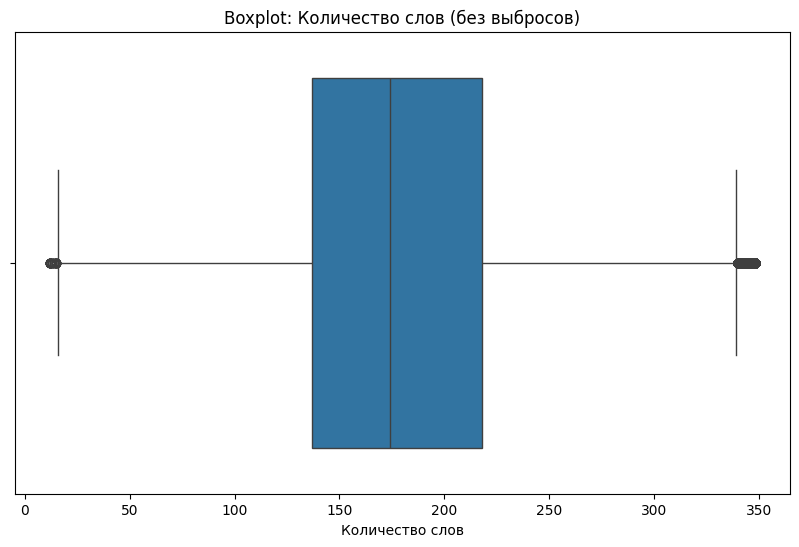

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_filtered["word_count"].to_list())
plt.title("Boxplot: Количество слов (без выбросов)")
plt.xlabel("Количество слов")
plt.show()

In [30]:
df = df_filtered.drop("word_count")

In [31]:
df.shape

(718088, 2)

### Составим репрезентативную выборку

In [32]:
df = df.sample(n=100_000, seed=RANDOM_STATE)
print(df.shape)
display(df.sample(3))

(100000, 2)


topic,content
str,str
"""Мир""","""При взрыве в Манчестере постра…"
"""Экономика""","""Fortune назвал самых плохих ге…"
"""Россия""","""Матвиенко взяла под личный кон…"


In [33]:
df.write_parquet("../data/interim/hw_1.parquet")

## Этап 2 - Предобработка данных

Мною выбраны классические шаги предобработки для текстов без особенностей (не заметил их на EDA)
- Нижний регистр
- Удаление цифр и пунктуации
- Токенизация и лемматизация текста
- Удаление стоп-слов (незначащих частей речи типа союзов, артиклей)

### Инициализируем необходимые объекты Natasha для сегментации и лемматизации

In [34]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
tagger = NewsMorphTagger(NewsEmbedding())

In [35]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[\d]+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(tagger)
    
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    
    tokens = [token.lemma for token in doc.tokens if token.pos in {"NOUN", "VERB", "ADJ", "ADV"}]
    return " ".join(tokens)

### Проверим

In [36]:
preprocess_text("Привет, мир!")

'привет мир'

### Предобработаем данные

In [ ]:
clean_contents = [preprocess_text(text) for text in df["content"]]

In [41]:
df = df.with_columns(pl.Series("clean_content", clean_contents))

In [42]:
df.sample(3)

topic,content,clean_content
str,str,str
"""Интернет и СМИ""","""""Время"" получило ""ТЭФИ"" как лу…","""время получить тэфи хороший ин…"
"""Наука и техника""","""Израиль показал беспилотник дл…","""израиль показать беспилотник р…"
"""Мир""","""Более миллиона китайцев эвакуи…","""более миллион китаец эвакуиров…"


### Кодируем целевую переменную topic в числовой формат для обучения

In [43]:
label_encoder = LabelEncoder()
topics = df["topic"].to_list()
encoded_topics = label_encoder.fit_transform(topics)
df = df.with_columns(pl.Series("encoded_topic", encoded_topics))

In [44]:
df.sample(3)

topic,content,clean_content,encoded_topic
str,str,str,i64
"""Экономика""","""Владельцы бренда ""Флагман"" не …","""владелец бренд флагман продава…",14
"""Экономика""","""Вместе с Вайнштоком из ""Олимпс…","""вместе вайншток олимпстрой уйт…",14
"""Наука и техника""","""Электронные паспорта придут на…","""электронный паспорт прийти пом…",8


In [45]:
df.write_parquet("../data/processed/hw_1.parquet")

## Этап 4 - Разделим выборки

In [46]:
X = df.select("clean_content").to_series().to_list()
y = df.select("encoded_topic").to_series().to_list()

In [47]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=RANDOM_STATE)

In [48]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

## Этап 5 - Dummy Classifier

Используем DummyClassifier, который предсказывает наиболее частый класс

In [51]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [54]:
y_dummy_pred = dummy_clf.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_dummy_pred)
print(f"Baseline accuracy (DummyClassifier): {baseline_accuracy:.4f}")

Baseline accuracy (DummyClassifier): 0.2169


### Вывод

Качество классификации плохое, эта модель не решает задачу.

## Этап 6 - Построение и обучение моделей

In [55]:
pipeline_count = Pipeline([
    ("vect", CountVectorizer()),
    ("clf", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

pipeline_tfidf = Pipeline([
    ("vect", TfidfVectorizer()),
    ("clf", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

### Определим сетки параметров

Выберем стандартные значения параметров широким фронтом наиболее значимых параметров для комбинации векторизатор + LR, а далее их уточним их.

Используем GridSearchCV с cv=3 для поиска оптимальных параметров, будем оценивать по accuracy.

In [57]:
param_grid_count = {
    "vect__min_df": [1, 3, 5],
    "vect__max_df": [0.1, 0.5, 0.9, 1.0],
    "clf__C": [0.1, 1, 10]
}
param_grid_tfidf = {
    "vect__min_df": [1, 3, 5],
    "vect__max_df": [0.1, 0.5, 0.9, 1.0],
    "clf__C": [0.1, 1, 10]
}

In [59]:
grid_count = GridSearchCV(pipeline_count, param_grid_count, cv=3, n_jobs=-1, scoring="accuracy")
grid_tfidf = GridSearchCV(pipeline_tfidf, param_grid_tfidf, cv=3, n_jobs=-1, scoring="accuracy")

In [ ]:
grid_count.fit(X_train, y_train)

In [ ]:
grid_tfidf.fit(X_train, y_train)

In [62]:
print(f"Best parameters for CountVectorizer pipeline: {grid_count.best_params_}")
print(f"Best cross-validation accuracy (CountVectorizer): {grid_count.best_score_:.4f}")
print(f"Best parameters for TfidfVectorizer pipeline: {grid_tfidf.best_params_}")
print(f"Best cross-validation accuracy (TfidfVectorizer): {grid_tfidf.best_score_:.4f}")

Best parameters for CountVectorizer pipeline: {'clf__C': 0.1, 'vect__max_df': 0.9, 'vect__min_df': 1}
Best cross-validation accuracy (CountVectorizer): 0.8021
Best parameters for TfidfVectorizer pipeline: {'clf__C': 10, 'vect__max_df': 0.9, 'vect__min_df': 1}
Best cross-validation accuracy (TfidfVectorizer): 0.8104


### Посмотрим score на валидационной выборке

In [66]:
y_val_pred_count = grid_count.predict(X_val)
val_accuracy_count = accuracy_score(y_val, y_val_pred_count)
print(f"Validation accuracy for best pipeline (CountVectorizer): {val_accuracy_count:.4f}")

Validation accuracy for best pipeline (CountVectorizer): 0.8055


In [67]:
y_val_pred_tfidf = grid_tfidf.predict(X_val)
val_accuracy_tfidf = accuracy_score(y_val, y_val_pred_tfidf)
print(f"Validation accuracy for best pipeline (TfidfVectorizer): {val_accuracy_tfidf:.4f}")

Validation accuracy for best pipeline (TfidfVectorizer): 0.8137


### Выводы

Получили качество 81% на модели с TFIDF, что вполне неплохо и может быть использовано в MVP реального проекта (80% зачастую является психологическим барьером для заказчика).

Качество не удалось значительно улучить с помощью подбора гиперпараметров.

## Этап 7 - Выберем лучшую модель и оценим

In [63]:
if grid_count.best_score_ >= grid_tfidf.best_score_:
    best_pipeline = grid_count.best_estimator_
    best_pipeline_name = "CountVectorizer"
else:
    best_pipeline = grid_tfidf.best_estimator_
    best_pipeline_name = "TfidfVectorizer"

In [69]:
y_test_pred = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Validation accuracy for best pipeline ({best_pipeline_name}): {test_accuracy:.4f}")

Validation accuracy for best pipeline (TfidfVectorizer): 0.8195


### Выводы

Качество на отложенной выборке составило 82%, что весьма солидно

### Возможные улучшения

- Определить точный набор интересующих классов
- Провести более тщательный EDA, погрузиться в тексты
- Использовать более мощные модели и токенизаторы (DL, Transformers...)